#E6 - MC
Implementation of a MC algorithm to compute $\pi$ with a circle of diameter D within a square of side length L.

In [1]:
import random
random.seed()

In [2]:
def generate_sample(l):
    return ((random.random() - 0.5) * l, (random.random() - 0.5) * l)

In [3]:
def is_in_circle(d, x, y):
    return x**2 + y**2 <= (d/2.0)**2

In [7]:
def estimate_pi(n_samples, l, d):
    n_in_circle = 0
    for i in range(n_samples):
        if is_in_circle(d, *generate_sample(l)):
            n_in_circle += 1
    return n_in_circle * l**2 / (d/2.0)**2 / n_samples

In [8]:
for n in (1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000):
    print(estimate_pi(n, 5, 3))

3.0888888888888886
3.25
3.2444444444444445
3.102777777777778
3.10625
3.1368055555555556
3.1427083333333337
3.159288194444444
3.1424913194444444


#E7 - Metropolis-Hastings method (MCMC)
Computation of a single-particle photon gas occupancy number $\langle n_j \rangle$ with the Metropolis–Hastings algorithm. The analytical expressions for the potential energy and occupancy number of an N-particle photon gas are
$$\mathcal{U} = \sum_j^N n_j \epsilon_j$$
$$\langle n_j \rangle = \frac{1}{e^{\beta \epsilon_j} - 1}$$

In [9]:
import math
import random

In [10]:
def generate_trial(n0):
    return n0 + 2 * random.randint(0, 1) - 1

In [11]:
def accept_trial(n0, n1, be):
    if n0 == 0 and n1 < 0:
        return n0
    if n1 < n0:
        return n1
    if math.exp(-be * (n1 - n0)) >= random.random():
        return n1
    else:
        return n0    

In [18]:
def estimate_occupancy(n0, be, n_samples):
    samples = {n0: 1}
    n = n0
    for i in range(n_samples):
        n = accept_trial(n, generate_trial(n), be)
        if i > 100:
            try:
                samples[n] += 1
            except KeyError:
                samples[n] = 1
    return sum([key * value for key, value in samples.items()]) / float(n_samples)

In [13]:
def analytical_occupancy(be):
    return 1 / (math.exp(be) - 1)

In [19]:
BE = 1
print(analytical_occupancy(BE))
print(estimate_occupancy(3, BE, 100000))

0.5819767068693265
0.57805


#Why do we need take into account the rejected samples?
To satisfy detailed balance. We have:
* **Proposal distribution** $\alpha(n|o)$: probability of generating as next state $n$ given that the current state is $o$.
* **Acceptance probability** $acc(n|o)$: probability of accepting trial generated by $\alpha(n|o)$.
* **Transition probability** $\pi(n|o) = \alpha(n|o) \cdot acc(n|o)$: probability of transitioning from state $o$ to $n$.
* **Stationary distribution** $\mathcal{N}(o)$: proportional to the probability of state $o$.

Detailed balance is given by
$$\mathcal{N}(o) \cdot \pi(n|o) = \mathcal{N}(n) \cdot \pi(o|n)$$

and **assuming $\alpha(n|o)$ to be symmetric** (which is the case for Metropolis-Hastings) implies

$$\mathcal{N}(o) \cdot acc(n|o) = \mathcal{N}(n) \cdot acc(n|o)$$

In the case where states $o$ and $n$ are equally probable (i.e. $\mathcal{N}(o) = \mathcal{N}(n)$) we must have $acc(n|o) = acc(o|n)$ in order to satisfy the equation above. Otherwise, if state $o$ is less probable than state $n$ we need to "use" the acceptance probability factor to estabilish detailed balance. Metropolis-Hastings use (among the many possible solutions)
$$\mathcal{N}(o) \cdot \frac{\mathcal{N}(n)}{\mathcal{N}(o)} = \mathcal{N}(n) \cdot 1$$

Note that in the opposite case (i.e. $\mathcal{N}(o) > \mathcal{N}(n)$) we would have $acc(n|o) = 1$ and $acc(n|o) = \mathcal{N}(o)/\mathcal{N}(n)$ instead.

If we ignored the rejected samples, then the acceptance probability used by the algorithm would effectively always be 1 and detailed balance would not be satisfied unless all the states are equally probable.

#How to compute temperature and pressure during a simulation?
What we have readily available in a simulation are momenta $\mathbf{p}_i$ and pairwise forces $\mathbf{F}_{ij}$ and distances $r_{ij}$ of the particles. We want to find temperature and pressure based on this information.

###Temperature
If we **ignore the rotational kinetic energy and other modes of motion** of the molecules that contribute to it, we can simply consider the **temperature in connection with the average translational kinetic energy**. We start from the Boltzmann distribution for a single particle in one dimension applied to the translational kinetic energy

$$f(E) = A e^{-E/kT} \qquad \implies \qquad f(v) = \sqrt{\frac{m}{2\pi kT}} e^{-mv^2/kT}$$

We can find the average kinetic energy as

$$\langle \frac{mv^2}{2} \rangle = \frac{m}{2} \langle v^2 \rangle = \frac{m}{2} \int_{-\infty}^{\infty} v^2 f(v) dv = \frac{kT}{2}$$

and in 3 dimensions

$$\langle \frac{mv^2}{2} \rangle = \frac{3}{2}kT $$

thus approximately we can write

$$\boxed{T = \frac{1}{3Nk}\sum_i \frac{\mathbf{p}_i \cdot \mathbf{p}_i}{2m_i}}$$

###Pressure
We start from the Clausius virial function

$$ W = \sum_i \mathbf{r}_i \cdot \mathbf{F}_i = \sum_i \mathbf{r}_i \cdot m_i \mathbf{\ddot{r}}_i $$

we take the time average and integrate by parts

$$ lim_{\tau \to \infty} \frac{1}{\tau} \int_0^{\tau} \sum_i \mathbf{r}_i \cdot m_i \mathbf{\ddot{r}}_i = lim_{\tau \to \infty} m_i \sum_i \frac{\mathbf{\dot{r}}_i(\tau) \cdot \mathbf{r}_i(\tau) - \mathbf{\dot{r}}_i(0) \cdot \mathbf{r}_i(0)}{\tau} - lim_{\tau \to \infty} \frac{1}{\tau} \int_0^{\tau} \sum_i m_i \mathbf{\dot{r}}_i \cdot \mathbf{\dot{r}}_i $$

the first term is 0 in a confined space, so under ergodic hypothesis

$$W = - lim_{\tau \to \infty} \frac{1}{\tau} \int_0^{\tau} \sum_i m_i \mathbf{\dot{r}}_i \cdot \mathbf{\dot{r}}_i = -2 \langle K.E. \rangle = -3NkT $$

Now we need to connect this to the macroscopic definition of pressure. We take a box of side $L$ and divide the force in internal and external. The virial gets decomposed then in $W = W_{int} + W_{ext}$ were the second term comes from the forces of the walls (the pressure). The external force in each of the three directions is $PL^2$ so the average $W_{ext} = L\cdot PL^2 + L\cdot PL^2 + L\cdot PL^2 = 2PV$. Thus

$$\langle \sum_i \mathbf{r} \cdot \mathbf{F}^{int}\rangle - 3PV = -3NkT$$

thus

$$\boxed{P = \frac{NkT}{V} + \frac{1}{3V} \sum_i \mathbf{r}_i \cdot \mathbf{F}_i^{int} = \frac{NkT}{V} + \frac{1}{3V} \sum_i \sum_{j>i} \mathbf{r}_{ij} \cdot \mathbf{F}_{ij}}$$


#E8 - MC simulation of Lennard-Jones system
Compute pressure of a Lennard-Jones gas in an NVT ensemble.

In [1]:
import copy
import math
import random
import pickle

random.seed()

In [2]:
class JLSimulation:
    
    def __init__(self, n_part, temperature, rho, epsilon, sigma):
        """Generate system of particles in random position in a cubic box with
        the right volume for the given density."""
        self.temp = temperature
        self.epsilon = epsilon  # LJ epsilon parameter
        self.sigma = sigma  # LJ sigma parameter
        
        self.box_side = (float(n_part) / rho)**(1 / 3.0)
        self.dr = self.box_side / 8.0  # Initial maximum displacement
        self.rc = self.box_side / 2.0  # cut-off radius

        self.energy = 0.0  # energy of the current system configuration
        self.virial = 0.0  # virial of the current system configuration
        self.energies = []  # history of the energy per particle
        self.pressures  = []  # history of the system pressure
        self.trajectory = []  # history of the system positions
        
        self.n_accepted = 0  # number of accepted MC moves
        self.n_attempts = 0  # number of attempted MC moves
        self.n_accepted_old = 0  # number of accepted MC moves
        self.n_attempts_old = 0  # number of attempted MC moves        

        # Initialize energy and pressure
        self._generate_lattice(n_part)
        self._compute_energy_virial()
        self._sample()
    
    def _generate_random_positions(self, n_part):
        self.positions = [[random.uniform(0, self.box_side) for j in range(3)]
                          for i in range(n_part)]
    
    def _generate_lattice(self, n_part):
        n_part_per_side = int(math.ceil(n_part**(1 / 3.0)))
        offset = float(self.box_side) / n_part_per_side
        self.positions = [[0.0, 0.0, 0.0] for j in range(n_part)]
        for i, part in enumerate(self.positions):
            part[0] = (i % n_part_per_side) * offset
            part[1] = ((i / n_part_per_side) % n_part_per_side) * offset
            part[2] = ((i / n_part_per_side**2) % n_part_per_side) * offset
        
    def _compute_particle_energy_virial(self, i, ii=0):
        """Compute interacting energy and virial between particles i and ii,ii+1,...,N."""
        energy = 0.0
        virial = 0.0
        half_box = self.box_side / 2.0
        for j in range(ii, len(self.positions)):
            if j == i:
                continue

            dpos = [self.positions[i][k] - self.positions[j][k] for k in range(3)]

            # Nearest-image convention
            for k, dx in enumerate(dpos):
                if dx > half_box:
                    dpos[k] -= self.box_side
                elif dx < -half_box:
                    dpos[k] += self.box_side

            # Compute energy and virial
            r = math.sqrt(dpos[0]**2 + dpos[1]**2 + dpos[2]**2)
            if r < self.rc:  # cutoff
                energy += 4 * self.epsilon * ((self.sigma / r)**12 - ((self.sigma / r)**6))
                # virial = r_ij . F_ij = - r * dU/dr
                virial += 24 * self.epsilon * (2 * (self.sigma / r)**12 - ((self.sigma / r)**6))

        return energy, virial
    
    def _compute_energy_virial(self):
        """Compute total energy and virial function for the system."""
        self.energy = 0.0
        self.virial = 0.0
        for i in range(len(self.positions)):
            energy_i, virial_i = self._compute_particle_energy_virial(i, i + 1)
            self.energy += energy_i
            self.virial += virial_i
    
    def _sample(self):
        """Saves the energy per particle and the pressure of the current configuration."""
        n_part = float(len(self.positions))
        vol = self.box_side**3
        self.energies.append(self.energy / n_part)
        self.pressures.append(n_part * self.temp / vol + self.virial / 3 / vol)
        self.trajectory.append(self.positions[:])
    
    def _mc_move(self):
        """MC move of one particle and update energy and virial of the new configuration."""
        beta = 1 / float(self.temp)
        self.n_attempts += 1
        
        # Select random particle
        i = random.randint(0, len(self.positions) - 1)
        energy_old, virial_old = self._compute_particle_energy_virial(i)
        
        # Random displacement
        old_positions = copy.deepcopy(self.positions[i])
        for k, p in enumerate(self.positions[i]):
            self.positions[i][k] = p + (random.random() - 0.5) * self.dr
        energy_new, virial_new = self._compute_particle_energy_virial(i)
        
        # Accept/reject
        if random.random() <= math.exp(-beta * (energy_new - energy_old)):  # accept
            self.n_accepted += 1
            self.energy += energy_new - energy_old
            self.virial += virial_new - virial_old
            
            # Put particle in simulation box
            for k, p in enumerate(self.positions[i]):
                if p < 0.0:
                    self.positions[i][k] += self.box_side
                elif p > self.box_side:
                    self.positions[i][k] -= self.box_side
        else:  # reject - restore old positions
            self.positions[i] = old_positions
    
    def _adjust_displacement(self):
        """Adjust maximum displacement such that 50% of moves is accepted."""
        dacc = float(self.n_accepted - self.n_accepted_old)
        datt = float(self.n_attempts - self.n_attempts_old)

        self.n_attempts_old = self.n_attempts
        self.n_accepted_old = self.n_accepted
        new_dr = self.dr * 2 * dacc / datt  # the 2 factor is for the 50% accepted moves

        # Limit the change
        if new_dr / self.dr > 1.5:
            new_dr = 1.5 * self.dr
        elif new_dr / self.dr < 0.5:
            new_dr = 0.5 * self.dr

        if new_dr > self.box_side / 4.0:
            new_dr = self.box_side / 4.0

        self.dr = new_dr
    
    def run(self, eq_cycles, prod_cycles, n_steps, verbose=False):
        for phase, n_cycles in enumerate([eq_cycles, prod_cycles]):
            self.n_accepted = 0
            self.n_attempts = 0
            self.n_accepted_old = 0
            self.n_attempts_old = 0
            
            for i in range(n_cycles):
                if verbose:
                    print('\rphase {}, cycle {}'.format(phase, i), end='')
                for j in range(n_steps):
                    self._mc_move()
                if phase == 1:  # production
                    self._sample()
                if i % n_cycles/5:               # we can't adjust dr too often because
                    self._adjust_displacement()  # it breaks detailed balance
        
    def analyze(self):
        energy = sum(self.energies) / len(self.energies)
        pressure = sum(self.pressures) / len(self.pressures)
        acceptance = self.n_accepted / float(self.n_attempts)
        
        return energy, pressure, acceptance
        

In [3]:
# Configuration
# -------------
N_EQUIL = 100  # Number of equilibration cycles
N_PROD = 1000  # Number of production cycles
N_STEPS = 100  # Number of MC steps per cycle

# Thermodynamics NVT ensemble
N_PART = 100  # Number of particles
TEMP = 2.0  # Temperature (reduced units T*k/epsilon)
DENSITIES = [0.1 * i for i in range(1, 10)]

# Potential parameters
SIGMA = 1.0
EPSILON = 1.0

In [23]:
for i, rho in enumerate(DENSITIES):
    simulation = JLSimulation(N_PART, TEMP, rho, EPSILON, SIGMA)
    simulation.run(N_EQUIL, N_PROD, N_STEPS)
    pickle.dump(simulation, open('simulation0{}.pickle'.format(i+1), 'wb'))

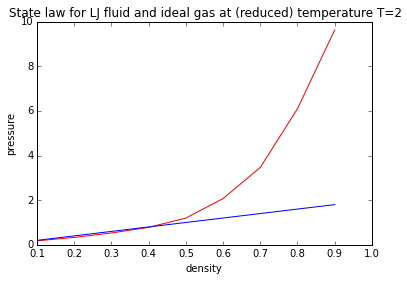

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

lj_pressures = []
for i in range(len(DENSITIES)):
    simulation = pickle.load(open('simulation0{}.pickle'.format(i+1), 'rb'))
    lj_pressures.append(simulation.analyze()[1])
ideal_pressures = [rho * TEMP for rho in DENSITIES]

plt.plot(DENSITIES, lj_pressures, 'r', DENSITIES, ideal_pressures, 'b')
plt.title('State law for LJ fluid and ideal gas at (reduced) temperature T=2')
plt.xlabel('density')
plt.ylabel('pressure')
plt.show()